In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.utils import save_image
import torchvision.transforms as tt
import torchvision.models as models
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from io import BytesIO
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import save_image
import os
import copy
import sys

#import telebot
# from telebot.async_telebot import AsyncTeleBot
# import asyncio

In [ ]:
!pip install pyTelegramBotAPI

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 157 kB 14.1 MB/s 
  Created wheel for pyTelegramBotAPI: filename=pyTelegramBotAPI-4.5.1-py3-none-any.whl size=138116 sha256=d0f34b0e42c7fbfe43cf7b1465efd9443b905aca39e468f65c4e2ec54d4abf36
  Stored in directory: /root/.cache/pip/wheels/9a/90/69/89e4e68c819633d933753827fd4f3a22987e162b7404b092b5
Successfully built pyTelegramBotAPI


In [ ]:
!pip install aiohttp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 15.7 MB/s 
     |████████████████████████████████| 144 kB 58.0 MB/s 
     |████████████████████████████████| 271 kB 66.1 MB/s 
     |████████████████████████████████| 94 kB 3.9 MB/s 


In [6]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [9]:
dir = Path('/content/gdrive/MyDrive/photos')

In [ ]:
dir1 = Path('/content/gdrive/MyDrive/StyleTransfer/')

In [ ]:
os.listdir(dir1)[-1]

'.ipynb_checkpoints'

In [ ]:
len(photo_list)

2

In [ ]:
TOKEN = '5451898321:AAFC3iv6WTHJ1GYzyvqRn9yG-PTvcYXIP1k'
bot = AsyncTeleBot(TOKEN)
@bot.message_handler(commands=['start', 'content'])
async def start(message):
    await bot.send_message(message.chat.id, 'Send your image and then style photo that you want')

imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize((imsize, imsize)),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor
@bot.message_handler(content_types=['photo', 'text'])
async def get_content_photo(message):
    file_path =  await bot.get_file(message.photo[-1].file_id)#.file_path
    file = await bot.download_file(file_path)
    print(file_path)
    src = '/content/gdrive/MyDrive/' + file_path
    with open(src, 'wb') as f:
        f.write(file)
    await bot.register_next_step_handler(message, get_style_photo)

async def get_style_photo(message):
    file_path =  await bot.get_file(message.photo[-1].file_id).file_path
    file =  await bot.download_file(file_path)
    print(file_path)
    src = '/content/gdrive/MyDrive/' + file_path
    with open(src, 'wb') as f:
        f.write(file)
    #bot.register_next_step_handler(message, send_photo)
    await bot.send_message(message.chat.id, 'Magic is happening')
    style_img, content_img, loaded_images = content_and_style(dir)
    input_img = content_img.clone()
    output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,\
                                content_img, style_img, input_img)
    resize_output = resize(loaded_images[-2], output)
    save_image(resize_output, '/content/gdrive/MyDrive/StyleTransfer/output_img.jpg')        
    dir1 = Path('/content/gdrive/MyDrive/StyleTransfer/')
    for file in os.listdir(dir1)[1:]:
        await bot.send_photo(message.chat.id, 
                        photo=open('/content/gdrive/MyDrive/StyleTransfer' + '/' + file, 'rb'))
    os.remove('/content/gdrive/MyDrive/StyleTransfer' + '/' + file)
    for file in os.listdir(dir)[1:]:
        os.remove('/content/gdrive/MyDrive/photos' + '/' + file)

# def send_photo(message):
#     #if message.text == 'photo':
#     bot.send_message(message.chat.id, 'Magic is happening')
#     style_img, content_img = content_and_style(dir)
#     input_img = content_img.clone()
#     output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
#                         content_img, style_img, input_img)
#     save_image(output, '/content/gdrive/MyDrive/StyleTransfer/output_img.jpg')        
#     dir1 = Path('/content/gdrive/MyDrive/StyleTransfer/')
#     for file in os.listdir(dir1)[1:]:
#         bot.send_photo(message.chat.id, 
#                         photo=open('/content/gdrive/MyDrive/StyleTransfer' + '/' + file, 'rb'))
#     os.remove('/content/gdrive/MyDrive/StyleTransfer' + '/' + file)
#     for file in os.lisdir(dir)[1:]:
#         os.remove('/content/gdrive/MyDrive/photos' + '/' + file)
# imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

# loader = transforms.Compose([
#     transforms.Resize((imsize, imsize)),  # scale imported image
#     transforms.ToTensor()])  # transform it into a torch tensor

def loader_images(dir):
    loaded_images = []
    for file in os.listdir(dir)[1:]:
        image = Image.open('/content/gdrive/MyDrive/photos' + '/' + file)
        loaded_images.append(image)
    return loaded_images
    
def image_loader(image):
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

def content_and_style(dir):
    loaded_images = loader_images(dir)
    style_img = image_loader(loaded_images[-1])
    content_img = image_loader(loaded_images[-2])
    return style_img, content_img, loaded_images
#loaded_images = loader_images(dir)

# style_img = image_loader(loaded_images[-1])
# content_img = image_loader(loaded_images[-2])

# assert style_img.size() == content_img.size(), \
    # "we need to import style and content images of the same size"

# def tensor_to_image(tensor):
#     tensor = tensor.cpu().detach()
#     tensor = tensor.squeeze(0)
#     unloader = transforms.ToPILImage()
#     #image = unloader(tensor)
#     return unloader

# @bot.message_handler()
# def get_user_files(message):
#     if message.text == 'photo':
#         bot.send_message(message.chat.id, 'Magic is happening')
#         style_img, content_img = content_and_style(dir)
#         input_img = content_img.clone()
#         output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
#                             content_img, style_img, input_img)
#         save_image(output, '/content/gdrive/MyDrive/StyleTransfer/img_2.jpg')
#         dir1 = Path('/content/gdrive/MyDrive/StyleTransfer/')
#         for file in os.listdir(dir1)[1:]:
#             bot.send_photo(message.chat.id, 
#                            photo=open('/content/gdrive/MyDrive/StyleTransfer' + '/' + file, 'rb'))
import asyncio
import nest_asyncio
asyncio.run(bot.polling())
nest_asyncio.apply()

ERROR:root:'bytes' object has no attribute 'status_code'
2022-06-21 09:49:22,152 (asyncio_helper.py:72 MainThread) ERROR - TeleBot: "Aiohttp ClientError: ClientOSError"
ERROR:TeleBot:Aiohttp ClientError: ClientOSError
2022-06-21 09:49:22,158 (async_telebot.py:234 MainThread) ERROR - TeleBot: "Request timeout. Request: method=get url=getUpdates params=<aiohttp.formdata.FormData object at 0x7f549c07db50> files=None request_timeout=20"
ERROR:TeleBot:Request timeout. Request: method=get url=getUpdates params=<aiohttp.formdata.FormData object at 0x7f549c07db50> files=None request_timeout=20


In [10]:
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize((imsize, imsize)),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor

def loader_images(dir):
    loaded_images = []
    for file in os.listdir(dir)[1:]:
        image = Image.open('/content/gdrive/MyDrive/photos' + '/' + file)
        loaded_images.append(image)
    return loaded_images
def image_loader(image):
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

def resize(prior_image, output):
    arr = np.array(prior_image)
    H, W = arr.shape[0], arr.shape[1]
    resize =  transforms.Resize((H, W))
    resize_output = resize(output) 
    return resize_output

loaded_images = loader_images(dir)

style_img = image_loader(loaded_images[-1])
content_img = image_loader(loaded_images[-2])

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

In [11]:
style_img.shape

torch.Size([1, 3, 512, 512])

In [12]:
content_img.shape

torch.Size([1, 3, 512, 512])

In [13]:
unloader = transforms.ToPILImage()

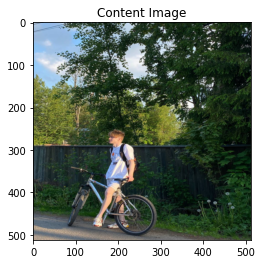

In [14]:
def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


# plt.figure()
# imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

In [15]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [ ]:
target = model(content_img)

In [ ]:
content_loss = ContentLoss(target)

In [ ]:
content_loss.loss

In [16]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [17]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [18]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [19]:
cnn

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [20]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [23]:
normalization = Normalization(cnn_normalization_mean, cnn_normalization_std)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


In [ ]:
normalization

Normalization()

In [21]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5'] # будем ставить стилевые слои на указанные слои в VGG

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

**ТЕСТИНГ**

In [24]:
model = nn.Sequential(normalization)

In [25]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

In [26]:
i = 0
content_losses = []
style_losses = []
for layer in cnn.children():
    if isinstance(layer, nn.Conv2d):
        i += 1
        name = 'conv_{}'.format(i)
    elif isinstance(layer, nn.ReLU):
        name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
        layer = nn.ReLU(inplace=False)
    elif isinstance(layer, nn.MaxPool2d):
        name = 'pool_{}'.format(i)
    elif isinstance(layer, nn.BatchNorm2d):
        name = 'bn_{}'.format(i)
    else:
        raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))
    model.add_module(name, layer)
    if name in content_layers_default:
        target = model(content_img).detach()
        content_loss = ContentLoss(target)
        model.add_module("content_loss_{}".format(i), content_loss)
        content_losses.append(content_loss)
    if name in style_layers_default:
        target_feature = model(style_img).detach()
        style_loss = StyleLoss(target_feature)
        model.add_module("style_loss_{}".format(i), style_loss)
        style_losses.append(style_loss)
for i in range(len(model) - 1, -1, -1):
    if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
        break
model = model[:(i + 1)]



In [27]:
model

Sequential(
  (0): Normalization()
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_1): StyleLoss()
  (relu_1): ReLU()
  (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_2): StyleLoss()
  (relu_2): ReLU()
  (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_3): StyleLoss()
  (relu_3): ReLU()
  (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (content_loss_4): ContentLoss()
  (style_loss_4): StyleLoss()
  (relu_4): ReLU()
  (pool_4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_5): StyleLoss()
)

In [30]:
model, style_losses, content_losses = get_style_model_and_losses(cnn,
        cnn_normalization_mean, cnn_normalization_std, style_img, content_img)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


In [33]:
model, style_losses, content_losses

(Sequential(
   (0): Normalization()
   (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (style_loss_1): StyleLoss()
   (relu_1): ReLU()
   (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (style_loss_2): StyleLoss()
   (relu_2): ReLU()
   (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (style_loss_3): StyleLoss()
   (relu_3): ReLU()
   (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (content_loss_4): ContentLoss()
   (style_loss_4): StyleLoss()
   (relu_4): ReLU()
   (pool_4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (conv_5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (style_loss_5): StyleLoss()
 ),
 [StyleLoss(), StyleLoss(), StyleLoss(), StyleLoss(), StyleLoss()],
 [ContentLoss()])

In [28]:
content_losses, style_losses

([ContentLoss()],
 [StyleLoss(), StyleLoss(), StyleLoss(), StyleLoss(), StyleLoss()])

In [ ]:
input_img = content_img.clone()

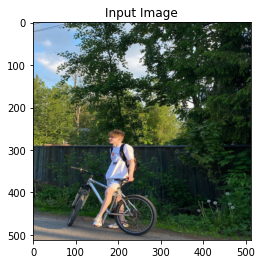

In [29]:
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

In [34]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img])
    return optimizer

In [39]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=1000,
                       style_weight=10000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

In [40]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


run [50]:
Style Loss : 2.226069 Content Loss: 16.157738

run [100]:
Style Loss : 1.907581 Content Loss: 13.489100

run [150]:
Style Loss : 1.670979 Content Loss: 11.920187

run [200]:
Style Loss : 1.445420 Content Loss: 11.051038

run [250]:
Style Loss : 1.227955 Content Loss: 10.531146

run [300]:
Style Loss : 1.040854 Content Loss: 10.215896

run [350]:
Style Loss : 0.881847 Content Loss: 10.000521

run [400]:
Style Loss : 0.735533 Content Loss: 9.838327

run [450]:
Style Loss : 0.621210 Content Loss: 9.727631

run [500]:
Style Loss : 0.530733 Content Loss: 9.632664

run [550]:
Style Loss : 0.473415 Content Loss: 9.560692

run [600]:
Style Loss : 0.425748 Content Loss: 9.502457

run [650]:
Style Loss : 0.394302 Content Loss: 9.453512

run [700]:
Style Loss : 0.373517 Content Loss: 9.411124

run [750]:
Style Loss : 0.358439 Content Loss: 9.376003

run [800]:
Style Loss : 0.347039 Content Loss: 9.346831

run [850]:
Style Loss : 0.338993 Content Loss: 9.319805

run [900]:
Style Loss : 0

In [ ]:
from torchvision.utils import save_image

In [ ]:
save_image(output, '/content/gdrive/MyDrive/StyleTransfer/img_1.jpg')

In [ ]:
content_img.shape

torch.Size([1, 3, 512, 512])

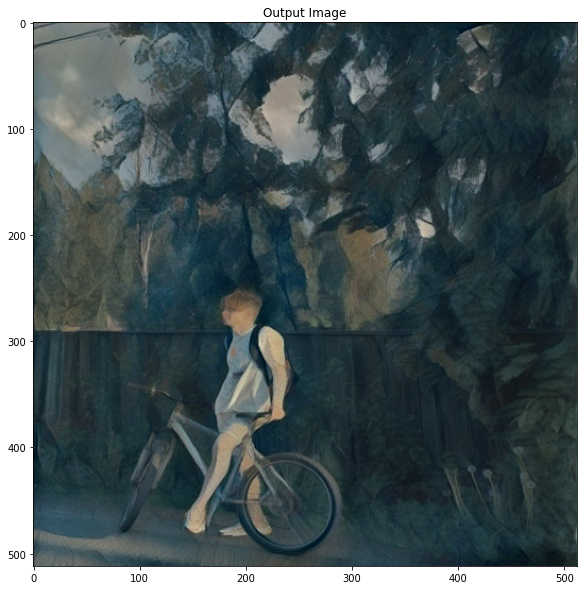

In [41]:
plt.figure(figsize=(15, 10))
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

In [42]:
def resize(prior_image, output):
    arr = np.array(prior_image)
    H, W = arr.shape[0], arr.shape[1]
    resize =  transforms.Resize((H, W))
    resize_output = resize(output) 
    return resize_output

In [ ]:
content_img.shape

torch.Size([1, 3, 512, 512])

In [43]:
resize(content_img, output)

TypeError: ignored